In [1]:
import pymysql
import pandas as pd
import numpy as np
import datetime
from sklearn import preprocessing
import lightgbm as lgb
import shap

import gc
import sys
sys.path.append(r'D:\jupyter files\waiting_time_project\my_tools')
import tools_for_os.for_df as ml_df
import tools_for_os.for_file as ml_fl

In [2]:
data_path = 'D:\\jupyter files\\data_waiting_time_project\\preprocess_data\\'
lightgbm_data_path = data_path + 'lightgbm_data\\'

ml_fl.create_folder(lightgbm_data_path)

D:\jupyter files\data_waiting_time_project\preprocess_data\lightgbm_data\ already existed!


In [3]:
def RMSE(pred_y, test_y):
    sq = sum((pred_y - test_y)**2) / len(pred_y)
#     sq = sum((pred_y - np.array(test_y.Actual_duration.tolist()))**2) / len(pred_y)
    rmse = np.sqrt(sq)
    return rmse

In [4]:
def MAE(pred_y, test_y):
    mae = sum(np.abs((pred_y - test_y))) / len(pred_y)
    return mae

##### 预处理后的数据，可以直接使用
数据保存在CSV 之后，会按照CSV 的格式来储存和加载数据，因此，就算保存前已经把一些分类变量编码后的结果转成了“category”类型，但是在CSV 中仍然变成了float 或int 类型

In [9]:
# data_display.to_csv(lightgbm_data_path + 'data_display.csv')
# data.to_csv(lightgbm_data_path + 'data.csv')
# train_x.to_csv(lightgbm_data_path + 'train_x.csv')
# train_y.to_csv(lightgbm_data_path + 'train_y.csv')
# test_x.to_csv(lightgbm_data_path + 'test_x.csv')
# test_y.to_csv(lightgbm_data_path + 'test_y.csv')

data_display = pd.read_csv(lightgbm_data_path + 'data_display.csv', index_col=0)
data_display = data_display.sample(frac = 1, random_state = 1)
data_display.reset_index(drop = True, inplace = True)

data = pd.read_csv(lightgbm_data_path + 'data.csv', index_col=0)
train_x = pd.read_csv(lightgbm_data_path + 'train_x.csv', index_col=0)
train_y = pd.read_csv(lightgbm_data_path + 'train_y.csv', index_col=0)
test_x = pd.read_csv(lightgbm_data_path + 'test_x.csv', index_col=0)
test_y = pd.read_csv(lightgbm_data_path + 'test_y.csv', index_col=0)

In [10]:
feature_cate = ['dxt_AliasName', 'Sex', 'AliasSerNum', 
                'month', 'week', 'hour', 'date','DoctorSerNum', 
                'TreatmentOrientation', 'FractionNumber',
                'UserName', 'RadiationId', 'CourseId', 'ResourceSerNum']

for col in feature_cate:
    try:
        data_display[col] = data_display[col].astype('category')
        train_x[col] = train_x[col].astype(int)
        test_x[col] = test_x[col].astype('category')
    except:
        print(f'no column: {col}')

no column: ResourceSerNum


In [11]:
print(f'The shape of train_y is {train_y.shape}')
train_y = train_y[(train_y.Actual_duration >= 10) &
                  (train_y.Actual_duration <= 60)]
print(f'The shape of train_y is {train_y.shape}')

print(f'\nThe shape of train_x is {train_x.shape}')
train_x = train_x.loc[train_y.index]
print(f'The shape of train_x is {train_x.shape}')

print(f'The shape of test_x is {test_x.shape}')
test_x = test_x.loc[test_y.index]
print(f'The shape of test_x is {test_x.shape}')

print(f'\nThe shape of data_display is {data_display.shape}')
data_display = data_display.loc[train_y.index]
print(f'The shape of data_display is {data_display.shape}')

print(f'\nThe shape of test_y is {test_y.shape}')
test_y = test_y[(test_y.Actual_duration >= 10) &
                (test_y.Actual_duration <= 60)]
print(f'The shape of test_y is {test_y.shape}')

The shape of train_y is (547461, 1)
The shape of train_y is (498219, 1)

The shape of train_x is (547461, 19)
The shape of train_x is (498219, 19)
The shape of test_x is (60830, 19)
The shape of test_x is (60830, 19)

The shape of data_display is (608291, 20)
The shape of data_display is (498219, 20)

The shape of test_y is (60830, 1)
The shape of test_y is (55288, 1)


mae 更好一点，rmse 和mse 可能会存在过拟合问题，测试结果的误差都比较大

In [12]:
# 创建模型，训练模型
print('='*40)
print('Train model')
gbm = lgb.LGBMRegressor(objective='mae', num_leaves=15, learning_rate=0.05,
                        n_estimators = 200)#num_leaves=31
gbm.fit(
    train_x[: int(train_x.shape[0] * 0.9)], train_y[: int(train_y.shape[0] * 0.9)],
    eval_set=[(train_x[int(train_x.shape[0] * 0.9):], train_y[int(train_y.shape[0] * 0.9):])],
    eval_metric='mae',
    early_stopping_rounds=100,
    verbose=200
)


Train model
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 5.15119
Did not meet early stopping. Best iteration is:
[200]	valid_0's l1: 5.15119


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=15, objective='mae',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [13]:
# # 测试
# pred_y = gbm.predict(test_x, num_iteration = gbm.best_iteration_)

# mae = MAE(pred_y, np.array(test_y.Actual_duration.tolist()))
# print(mae)

==============================================================

## shap

In [14]:
# print the JS visualization code to the notebook
shap.initjs()

##### 先将数据格式改变，这样后面能够正常显示分类变量

In [15]:
# 对于分类变量，需要显示原始变量值的话，就需要加载display
data_train_display = data_display.iloc[: int(data.shape[0] * 0.9)]
data_val_display = data_train_display[int(train_x.shape[0] * 0.9): ]
data_val_display.drop('Actual_duration', axis = 1, inplace = True)

data_val = train_x[int(train_x.shape[0] * 0.9): ]

data_val_y = train_y[int(train_y.shape[0] * 0.9): ]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
data_val.head()

,Scheduled_duration,age,TreatmentTime,ImagesTaken,MU,MUCoeff,dxt_AliasName,Sex,AliasSerNum,month,date,week,hour,DoctorSerNum,TreatmentOrientation,FractionNumber,UserName,RadiationId,CourseId
492743,15.0,82,0.780898,0,468.550,100.0000,12,1,0,11,763,5,3,23,7,6,54,657,1
492744,15.0,82,0.939677,0,563.818,100.0000,12,1,0,8,711,2,5,15,7,2,23,432,1
492745,15.0,56,0.230746,0,138.447,100.0000,8,0,0,5,896,5,9,0,7,39,95,42,1
492746,30.0,74,0.231522,0,138.918,100.0000,5,1,0,6,399,1,4,11,7,10,50,945,1
492747,60.0,54,0.002917,0,161.442,93.6539,0,0,0,6,663,3,7,17,7,2,90,12,1


In [17]:
data_val_display.head()

,Scheduled_duration,age,TreatmentTime,ImagesTaken,MU,MUCoeff,dxt_AliasName,Sex,AliasSerNum,month,date,week,hour,DoctorSerNum,TreatmentOrientation,FractionNumber,UserName,RadiationId,CourseId
492743,15.0,82,0.780898,0,468.550,100.0000,Prostate,Male,23,12,2017--12--01,5,9,747.0,HFS,15,ijawandha,1.2ARC2,C1
492744,15.0,82,0.939677,0,563.818,100.0000,Prostate,Male,23,9,2017--09--19,2,11,5131.0,HFS,11,abelli,1.2 ARC2,C1
492745,15.0,56,0.230746,0,138.447,100.0000,LGI,Female,23,6,2018--06--08,5,15,1001.0,HFS,5,sgaglia,1.1 ARC1,C1
492746,30.0,74,0.231522,0,138.918,100.0000,HN,Male,23,7,2016--07--04,1,10,4561.0,HFS,19,hli,1.3ARC3,C1
492747,60.0,54,0.002917,0,161.442,93.6539,Breast,Female,23,7,2017--07--12,3,13,5691.0,HFS,11,rkarant,1.1 ANT,C1


In [18]:
explainer = shap.TreeExplainer(gbm.booster_)
shap_values = explainer.shap_values(data_val[: 1000])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [19]:
shap.force_plot(
    explainer.expected_value, 
    shap_values[1], 
    data_val.iloc[1],
    data_val_display.iloc[1])

TypeError: Object of type int64 is not JSON serializable

In [20]:
data_val.dtypes

Scheduled_duration      float64
age                       int64
TreatmentTime           float64
ImagesTaken               int64
MU                      float64
MUCoeff                 float64
dxt_AliasName             int32
Sex                       int32
AliasSerNum               int32
month                     int32
date                      int32
week                      int32
hour                      int32
DoctorSerNum              int32
TreatmentOrientation      int32
FractionNumber            int32
UserName                  int32
RadiationId               int32
CourseId                  int32
dtype: object

In [21]:
data_val_display.dtypes

Scheduled_duration       float64
age                        int64
TreatmentTime            float64
ImagesTaken                int64
MU                       float64
MUCoeff                  float64
dxt_AliasName           category
Sex                     category
AliasSerNum             category
month                   category
date                    category
week                    category
hour                    category
DoctorSerNum            category
TreatmentOrientation    category
FractionNumber          category
UserName                category
RadiationId             category
CourseId                category
dtype: object

In [21]:
shap.force_plot(
    explainer.expected_value, 
    shap_values[: 1000], 
    data_val[: 1000],
    data_val_display[: 1000])

AssertionError: # of names must match data matrix!

In [ ]:
特征的排序是按照shapley value的平均绝对值，也就是特征对于预测的贡献，贡献越大的特征，也就是更重要的特征。
红色表示特征的取值更高，蓝色表示特征的取值更低。对于数值变量，我们可以从图像上直观地理解它们的含义。比如

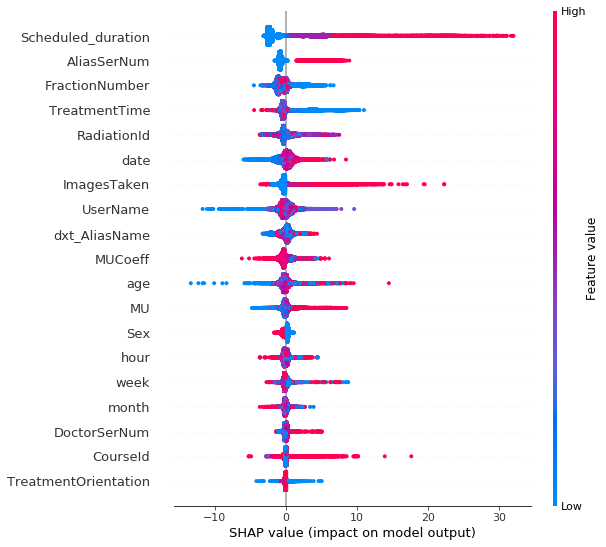

In [20]:
# summarize the effects of all the features
shap.summary_plot(shap_values, data_val)

In [ ]:
shap.dependence_plot(
    'Sex', 
    shap_values, 
    data_val, 
    display_features=X_display)

In [ ]:
data_display = pd.read_csv(lightgbm_data_path + 'data_display.csv', index_col=0)
data = pd.read_csv(lightgbm_data_path + 'data.csv', index_col=0)
train_x = pd.read_csv(lightgbm_data_path + 'train_x.csv', index_col=0)
train_y = pd.read_csv(lightgbm_data_path + 'train_y.csv', index_col=0)
test_x = pd.read_csv(lightgbm_data_path + 'test_x.csv', index_col=0)
test_y

In [30]:
scheduled_actual_mae = MAE(test_x.Scheduled_duration.values, np.array(test_y.Actual_duration.tolist()))
print(scheduled_actual_mae)

7.230447836781942


In [34]:
import matplotlib.pyplot as plt

In [43]:
plot_data = pd.DataFrame({'Actual_duration': test_y.Actual_duration.tolist(),
                          'Scheduled_duration': test_x.Scheduled_duration.tolist(),
                          'pred_y': pred_y})
plot_data.sort_values(by = ['Actual_duration', 'Scheduled_duration', 'pred_y'], inplace = True)

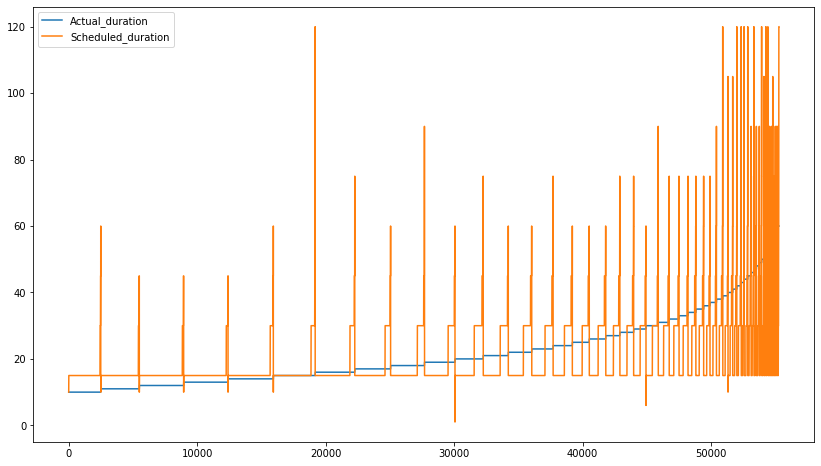

In [61]:
plot_data.sort_values(by = ['Actual_duration', 'Scheduled_duration'], inplace = True)
fig = plt.figure(figsize = (14, 8))
ax = plt.subplot(111)
x = range(len(pred_y))
y1 = plot_data.Actual_duration.tolist()
y2 = plot_data.Scheduled_duration.tolist()
y3 = plot_data.pred_y.tolist()
ax.plot(x, y1, label = 'Actual_duration')
ax.plot(x, y2, label = 'Scheduled_duration')
# ax.plot(x, y3, label = 'pred_y')
ax.legend()
plt.show()

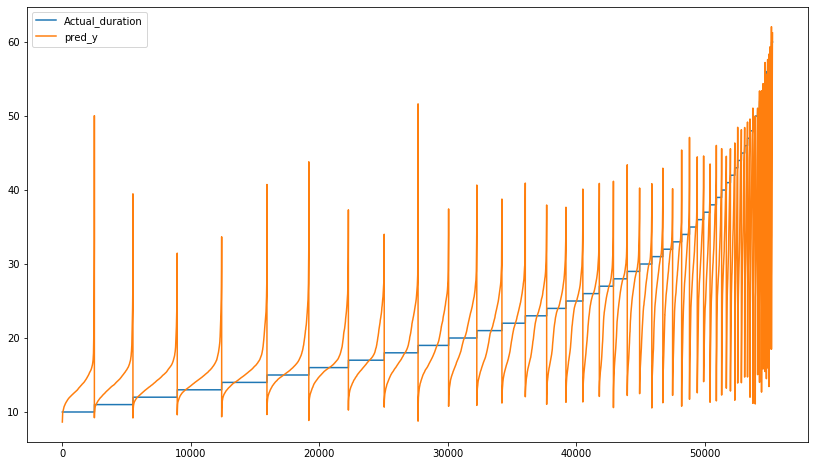

In [53]:
plot_data.sort_values(by = ['Actual_duration', 'pred_y'], inplace = True)
fig = plt.figure(figsize = (14, 8))
ax = plt.subplot(111)
x = range(len(pred_y))
y1 = plot_data.Actual_duration.tolist()
y2 = plot_data.Scheduled_duration.tolist()
y3 = plot_data.pred_y.tolist()
ax.plot(x, y1, label = 'Actual_duration')
# ax.plot(x, y2, label = 'Scheduled_duration')
ax.plot(x, y3, label = 'pred_y')
ax.legend()
plt.show()

In [54]:
np.abs(plot_data.Actual_duration - plot_data.pred_y)

33059     1.356797
49044     1.293577
15572     0.994427
24872     0.946553
44981     0.808629
38192     0.724928
5360      0.642453
7297      0.605059
35808     0.593574
10601     0.589963
46942     0.553389
12364     0.545599
48921     0.456935
47758     0.435900
39220     0.420569
732       0.350418
19539     0.328588
30265     0.278501
35628     0.258001
6204      0.183570
52967     0.175702
962       0.175345
21169     0.145233
13854     0.142688
34196     0.132071
19191     0.115790
5233      0.114852
44729     0.113146
33980     0.090095
7231      0.082021
           ...    
15742    10.910750
35334    10.214990
18816     9.929673
30299     9.090446
50269     8.469779
18169     8.225148
8278      6.936071
3977      6.442641
27193     5.585759
2355      3.563395
4369      2.634455
51815     2.173900
12122     2.026345
27335     1.671503
34291     1.494831
49127     1.337694
40225     0.338324
16866     0.286692
15975     0.198547
51191     0.115113
5966      0.090533
20689     0.

In [ ]:
计算测试集中每一个样本的mae，我们可以更细致地观察我们的预测结果。样本中最大的mae为44.56min，其中mae在5min以内的样本占比为0.7348。
从可视化的结果，可以直观地看出，预测值在真实值的两侧波动，少量数据会有显著的异常差异，这部分数据可能导致我们最终的mae偏大。
在删除mae>5min之后的样本之后，可以看出我们的模型较好地捕捉到了治疗时长变化的趋势。

我们在筛选样本的时候比较粗略，实际情况中的治疗时长异常值无法被完全剔除，同时样本中可能存在信息覆盖的问题，mae过大的数据可能

In [64]:
plot_data.mae.max()

44.55959159187767

In [ ]:
plot_data['mae'] = np.abs(plot_data.Actual_duration - plot_data.pred_y)
print(f'plot_data {plot_data.shape}')
plot_data_ = plot_data[plot_data.mae <= 3]
print(f'plot_data {plot_data_.shape}')
print(f'precent {plot_data_.shape[0] / plot_data.shape[0]}')
plot_data_.sort_values(by = ['Actual_duration', 'pred_y'], inplace = True)

plot_data (55288, 4)
plot_data (30655, 4)
precent 0.5544602807119086



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


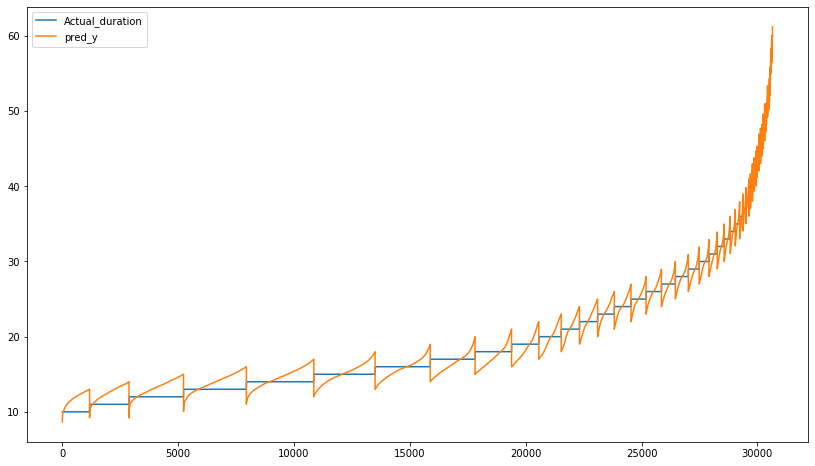

In [67]:
plot_data['mae'] = np.abs(plot_data.Actual_duration - plot_data.pred_y)
print(f'plot_data {plot_data.shape}')
plot_data_ = plot_data[plot_data.mae <= 3]
print(f'plot_data {plot_data_.shape}')
print(f'precent {plot_data_.shape[0] / plot_data.shape[0]}')
plot_data_.sort_values(by = ['Actual_duration', 'pred_y'], inplace = True)

fig = plt.figure(figsize = (14, 8))
ax = plt.subplot(111)
x = range(plot_data_.shape[0])
y1 = plot_data_.Actual_duration.tolist()
y2 = plot_data_.Scheduled_duration.tolist()
y3 = plot_data_.pred_y.tolist()
ax.plot(x, y1, label = 'Actual_duration')
# ax.plot(x, y2, label = 'Scheduled_duration')
ax.plot(x, y3, label = 'pred_y')
ax.legend()
plt.show()